In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import colorcet as cc
from adjustText import adjust_text

In [2]:
tf_e3_corrs = pd.read_pickle("pydata/tf_dependency_e3ls_expr_correlation_bylineage_dropna.pkl")

In [3]:
tf_e3_corrs.head()

,lineage,TF,E3_ligase,p-val,corr
0,Ampulla of Vater,TFAP2A,KDM2A,0.709839,-0.157329
1,Ampulla of Vater,TFAP2B,KDM2A,0.588720,0.227030
2,Ampulla of Vater,TFAP2C,KDM2A,0.195091,-0.511497
3,Ampulla of Vater,TFAP2D,KDM2A,0.350621,0.381823
4,Ampulla of Vater,TFAP2E,KDM2A,0.270403,-0.444031


In [4]:
tf_lin_filter = pd.read_pickle("pydata/tf_list_by_lineage.pkl")

In [5]:
tf_lin_filter.head()

,OncotreeLineage,TF,dependency,effect,n_models
2974,Biliary Tract,ADNP,0.262168,-0.261788,36
2975,Biliary Tract,ADNP2,0.051071,-0.039606,36
2976,Biliary Tract,AEBP1,0.066771,-0.084119,36
2978,Biliary Tract,AHDC1,0.108234,-0.125744,36
2981,Biliary Tract,AKAP8,0.060307,-0.079361,36


In [6]:
tf_e3_corrs.shape

(20203650, 5)

In [7]:
tf_e3_corrs = tf_e3_corrs[(tf_e3_corrs["TF"].isin(tf_lin_filter["TF"])) & (tf_e3_corrs["lineage"].isin(tf_lin_filter["OncotreeLineage"]))]

In [8]:
lineages = tf_e3_corrs["lineage"].unique()
tf_e3_corrs_fdrs = []
for lineage in lineages:
    lin_cors = tf_e3_corrs.loc[tf_e3_corrs["lineage"] == lineage].copy()
    lin_cors["fdr"] = fdrcorrection(lin_cors["p-val"].values)[1]
    tf_e3_corrs_fdrs.append(lin_cors)

In [9]:
tf_e3_corrs_fdrs = pd.concat(tf_e3_corrs_fdrs)

In [10]:
tf_e3_corrs_fdrs.head()

,lineage,TF,E3_ligase,p-val,corr,fdr
0,Biliary Tract,TFAP2A,KDM2A,0.828814,-0.037342,0.993790
1,Biliary Tract,TFAP2B,KDM2A,0.200057,-0.218687,0.928731
2,Biliary Tract,TFAP2C,KDM2A,0.082667,0.293189,0.873989
3,Biliary Tract,TFAP2D,KDM2A,0.165586,0.236139,0.919474
4,Biliary Tract,TFAP2E,KDM2A,0.447490,0.130668,0.969818


In [11]:
np.log10([0.1, 0.25])*-1

array([1.        , 0.60205999])

In [12]:
tf_e3_corrs_fdrs["log10q"] = np.log10(tf_e3_corrs_fdrs["fdr"])*-1

In [13]:
tf_e3_corrs_fdrs.to_pickle("pydata/tf_dependency_e3ls_expr_correlation_bylineage_fdr.pkl")

In [14]:
len(lineages)

22

In [15]:
color_palette = pd.read_pickle("pydata/lineage_palette.pkl")

In [16]:
tf_e3_corrs_fdrs["name"] = tf_e3_corrs_fdrs["TF"] + "-" + tf_e3_corrs_fdrs["E3_ligase"]

In [17]:
tf_e3_corrs_fdrs.head()

,lineage,TF,E3_ligase,p-val,corr,fdr,log10q,name
0,Biliary Tract,TFAP2A,KDM2A,0.828814,-0.037342,0.993790,0.002705,TFAP2A-KDM2A
1,Biliary Tract,TFAP2B,KDM2A,0.200057,-0.218687,0.928731,0.032110,TFAP2B-KDM2A
2,Biliary Tract,TFAP2C,KDM2A,0.082667,0.293189,0.873989,0.058494,TFAP2C-KDM2A
3,Biliary Tract,TFAP2D,KDM2A,0.165586,0.236139,0.919474,0.036460,TFAP2D-KDM2A
4,Biliary Tract,TFAP2E,KDM2A,0.447490,0.130668,0.969818,0.013310,TFAP2E-KDM2A


In [18]:
def get_volcano_plot(l):
    plt.figure(figsize=(4,4))
    ax = plt.subplot(111)
    l_corr =tf_e3_corrs_fdrs.loc[tf_e3_corrs_fdrs["lineage"] == l] 
    sig_df = l_corr[l_corr["log10q"] > 1].sort_values(by=["fdr"]).iloc[0:20,:]
    sns.scatterplot(data=l_corr[l_corr["fdr"] > 0.1], x = "corr", y = "log10q", 
                    s = 1, color = "grey")
    sns.scatterplot(data=l_corr[l_corr["fdr"] < 0.1], x = "corr", y = "log10q", 
                    s = 2)
    text = []
    for i, row in sig_df.iterrows():
        text.append(plt.text(x =row["corr"], y = row["log10q"], s = row["name"], fontsize=6)) 
    adjust_text(text, arrowprops = dict(arrowstyle="-", color = "red", alpha=1, lw=0.2))
    plt.title(l)
    ax.spines[['right', 'top']].set_visible(False)
    plt.xlabel("Pearson correlation")
    plt.ylabel("-log10(q-value)")
    plt.show()
    plt.clf()
    plt.close("all")

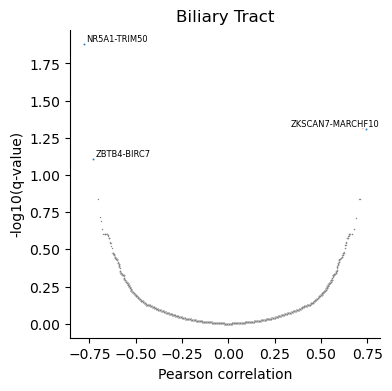

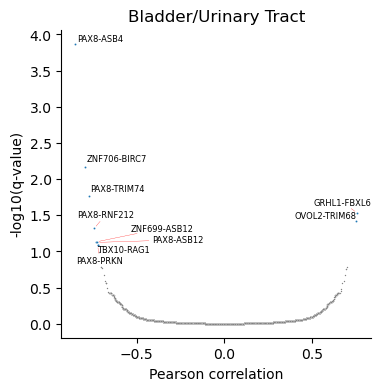

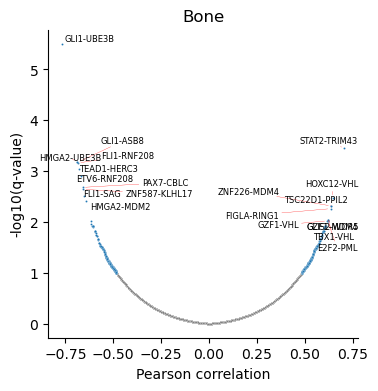

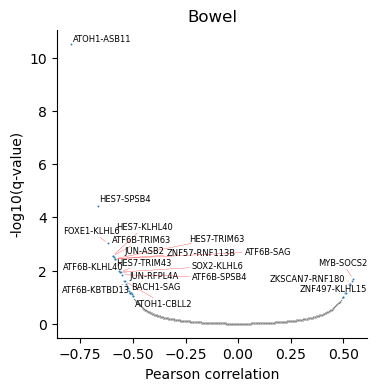

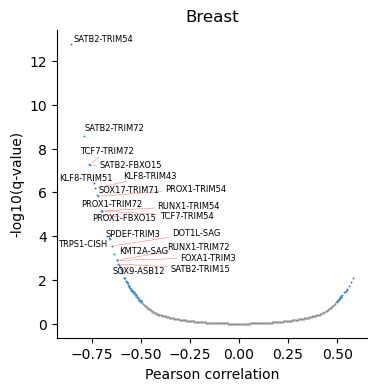

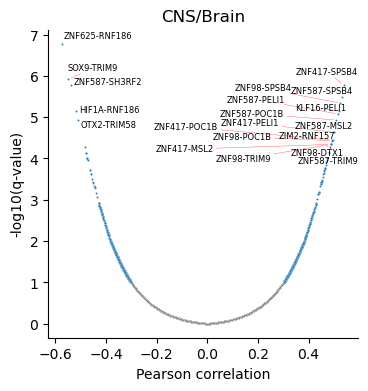

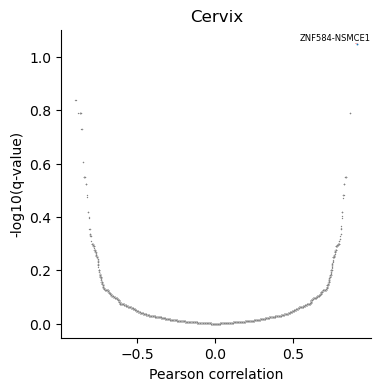

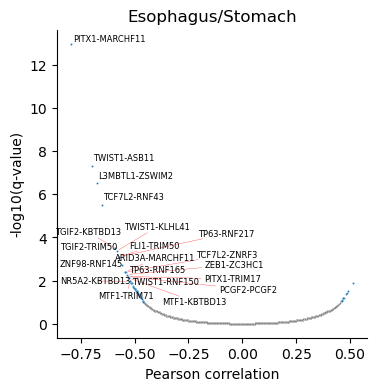

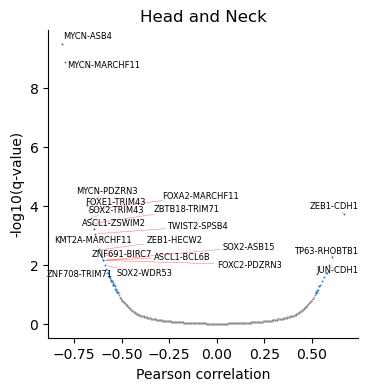

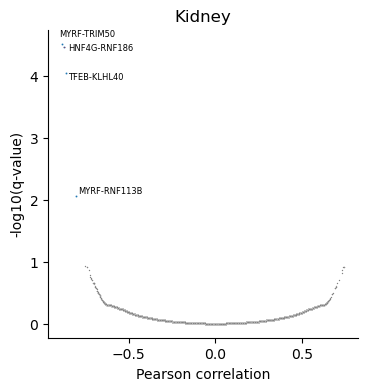

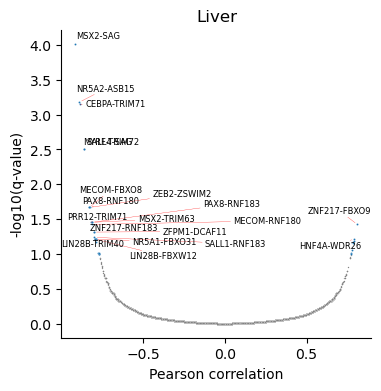

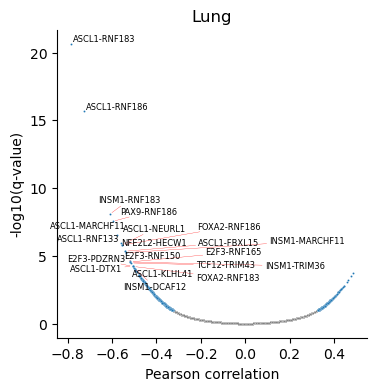

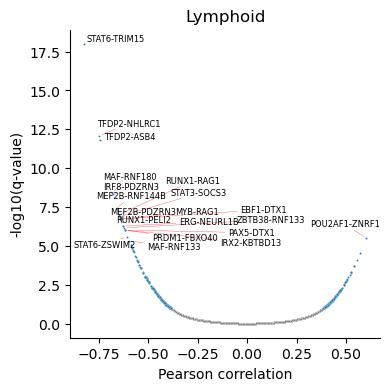

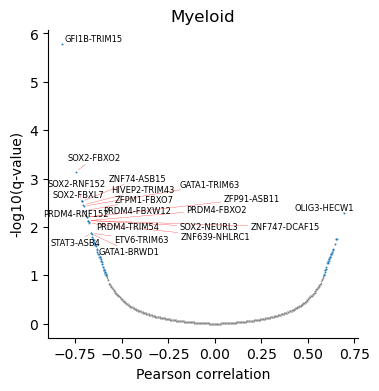

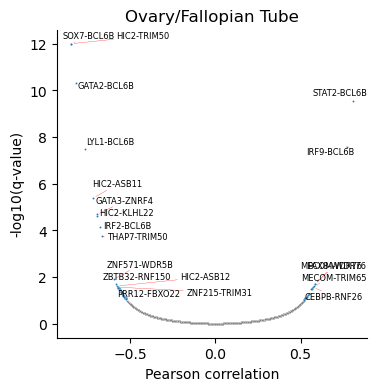

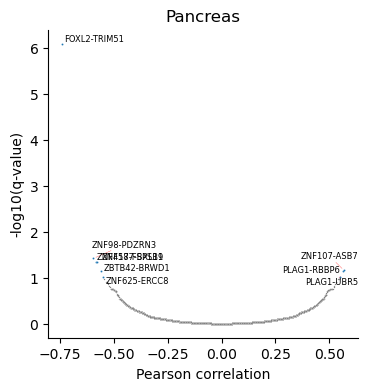

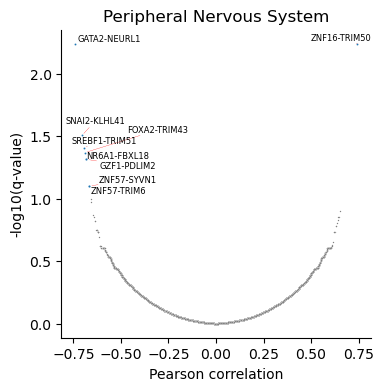

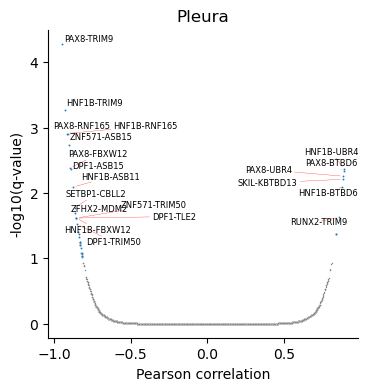

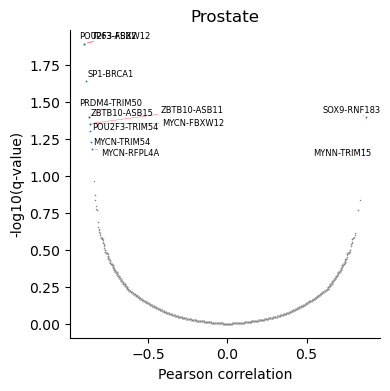

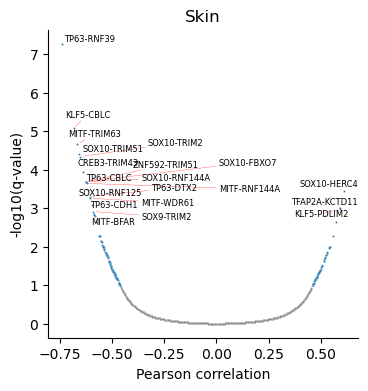

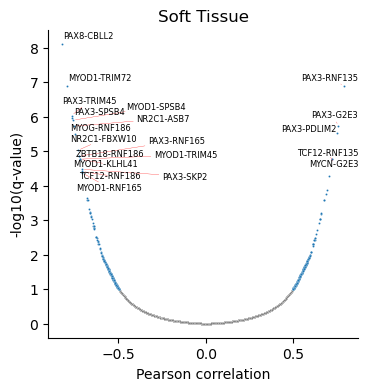

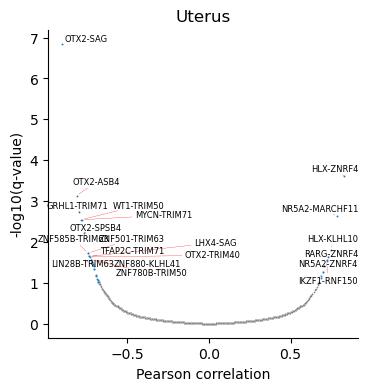

In [19]:
for lineage in lineages:
    get_volcano_plot(lineage)